In [ ]:
## Overfit and underfit
# the accuracy of our model on the validation data would peak after training for a number of epochs, and would then stagnate or start decreasing.
# overfitting : Although it's often possible to achieve high accuracy on the training set, what we really want is to develop models that generalize well to a testing set (or data they haven't seen before).
# underfitting : Underfitting occurs when there is still room for improvement on the test data.
    # This can happen for a number of reasons: If the model is not powerful enough, is over-regularized, or has simply not been trained long enough. 
    # This means the network has not learned the relevant patterns in the training data.
# explore several common regularization techniques, and use them to improve on a classification model.

In [1]:
# Setup

import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import regularizers

print(tf.__version__) 

2.2.0-dev20200501


In [2]:
!pip install -q git+https://github.com/tensorflow/docs

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

In [3]:
from  IPython import display
from matplotlib import pyplot as plt

import numpy as np

import pathlib
import shutil
import tempfile

In [4]:
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

In [5]:
# The Higgs Dataset
# It contains 11 000 000 examples, each with 28 features, and a binary class label.

gz = tf.keras.utils.get_file('HIGGS.csv.gz', 'http://mlphysics.ics.uci.edu/data/higgs/HIGGS.csv.gz')

2816409600/2816407858 [==============================] - 970s 0us/step


In [3]:
FEATURES = 28

In [4]:
ds = tf.data.experimental.CsvDataset(gz,[float(),]*(FEATURES+1), compression_type="GZIP")

NameError: name 'tf' is not defined

In [8]:
def pack_row(*row):
  label = row[0]
  features = tf.stack(row[1:],1)
  return features, label

In [9]:
# TensorFlow is most efficient when operating on large batches of data.
# So instead of repacking each row individually make a new Dataset that takes batches of 10000-examples, 
# applies the pack_row function to each batch, 
# and then splits the batches back up into individual records:

packed_ds = ds.batch(10000).map(pack_row).unbatch()

tf.Tensor(
[ 0.8692932  -0.6350818   0.22569026  0.32747006 -0.6899932   0.75420225
 -0.24857314 -1.0920639   0.          1.3749921  -0.6536742   0.9303491
  1.1074361   1.1389043  -1.5781983  -1.0469854   0.          0.65792954
 -0.01045457 -0.04576717  3.1019614   1.35376     0.9795631   0.97807616
  0.92000484  0.72165745  0.98875093  0.87667835], shape=(28,), dtype=float32)


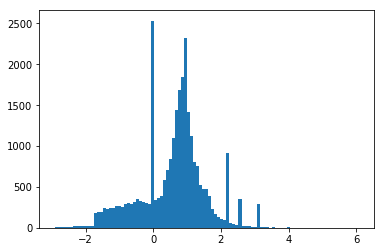

In [10]:
for features,label in packed_ds.batch(1000).take(1):
  print(features[0])
  plt.hist(features.numpy().flatten(), bins = 101)

In [11]:
N_VALIDATION = int(1e3)
N_TRAIN = int(1e4)
BUFFER_SIZE = int(1e4)
BATCH_SIZE = 500
STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE

In [12]:
#  Dataset.cache : method to ensure that the loader doesn't need to re-read the data from the file on each epoch:

validate_ds = packed_ds.take(N_VALIDATION).cache()
train_ds = packed_ds.skip(N_VALIDATION).take(N_TRAIN).cache()

In [13]:
train_ds 

<CacheDataset shapes: ((28,), ()), types: (tf.float32, tf.float32)>

In [14]:
validate_ds = validate_ds.batch(BATCH_SIZE)
train_ds = train_ds.shuffle(BUFFER_SIZE).repeat().batch(BATCH_SIZE) 

In [15]:
## Demonstrate overfitting
# to prevent overfitting is to start with a small model
# A model with a small number of learnable parameters (which is determined by the number of layers and the number of units per layer). 
# In deep learning, the number of learnable parameters in a model is often referred to as the model's "capacity".
# Always keep this in mind: deep learning models tend to be good at fitting to the training data, but the real challenge is generalization, not fitting.
# To find an appropriate model size, it's best to start with relatively few layers and parameters, then begin increasing the size of the layers or adding new layers until you see diminishing returns on the validation loss.
 

In [16]:
# Training procedure
# optimizers.schedules : Many models train better if you gradually reduce the learning rate during training. 

lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=STEPS_PER_EPOCH*1000,
  decay_rate=1,
  staircase=False)

def get_optimizer():
  return tf.keras.optimizers.Adam(lr_schedule)

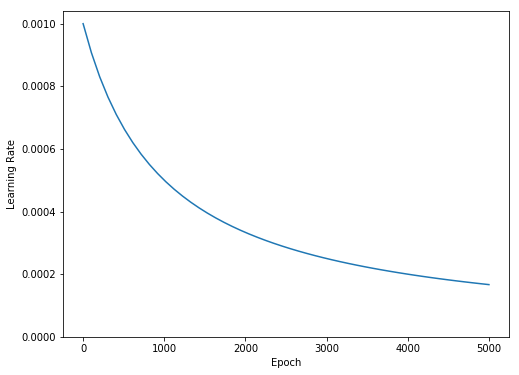

In [17]:
step = np.linspace(0,100000)
lr = lr_schedule(step)
plt.figure(figsize = (8,6))
plt.plot(step/STEPS_PER_EPOCH, lr)
plt.ylim([0,max(plt.ylim())])
plt.xlabel('Epoch')
_ = plt.ylabel('Learning Rate')
 

In [18]:
def get_callbacks(name):
  return [
    tfdocs.modeling.EpochDots(),
    tf.keras.callbacks.EarlyStopping(monitor='val_binary_crossentropy', patience=200),
    tf.keras.callbacks.TensorBoard(logdir/name),
  ]

In [19]:
def compile_and_fit(model, name, optimizer=None, max_epochs=10000):
  if optimizer is None:
    optimizer = get_optimizer()
  model.compile(optimizer=optimizer,
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=[
                  tf.keras.losses.BinaryCrossentropy(
                      from_logits=True, name='binary_crossentropy'),
                  'accuracy'])

  model.summary()

  history = model.fit(
    train_ds,
    steps_per_epoch = STEPS_PER_EPOCH,
    epochs=max_epochs,
    validation_data=validate_ds,
    callbacks=get_callbacks(name),
    verbose=0)
  return history

In [20]:
### Tiny model

tiny_model = tf.keras.Sequential([
    layers.Dense(16, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(1)
])

size_histories = {}

size_histories['Tiny'] = compile_and_fit(tiny_model, 'sizes/Tiny')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                464       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 481
Trainable params: 481
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Use `tf.data.Dataset.cardinality()
Instructions for updating:
use `tf.profiler.experimental.stop` instead.

Epoch: 0, accuracy:0.4854,  binary_crossentropy:0.9325,  loss:0.9325,  val_accuracy:0.4980,  val_binary_crossentropy:0.7998,  val_loss:0.7998,  
....................................................................................................
Epoch: 100, accuracy:0.5867,  binary_crossentropy:0.6315,  loss:0.6315,  val_accuracy:0.5760,  val_binary_crossentropy:0.6321,  val_loss:0.

(0.5, 0.7)

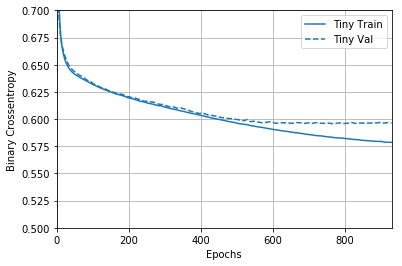

In [21]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'binary_crossentropy', smoothing_std=10)
plotter.plot(size_histories)
plt.ylim([0.5, 0.7]) 

In [22]:
### Small model

small_model = tf.keras.Sequential([
    # `input_shape` is only required here so that `.summary` works.
    layers.Dense(16, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(16, activation='elu'),
    layers.Dense(1)
])

size_histories['Small'] = compile_and_fit(small_model, 'sizes/Small')

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 16)                464       
_________________________________________________________________
dense_3 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 17        
Total params: 753
Trainable params: 753
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4805,  binary_crossentropy:0.7413,  loss:0.7413,  val_accuracy:0.4690,  val_binary_crossentropy:0.7106,  val_loss:0.7106,  
....................................................................................................
Epoch: 100, accuracy:0.6146,  binary_crossentropy:0.6191,  loss:0.6191,  val_accuracy:0.5930,  val_binary_crossentropy:0.6229,  val_loss:0.

In [23]:
### Medium model

medium_model = tf.keras.Sequential([
    layers.Dense(64, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(64, activation='elu'),
    layers.Dense(64, activation='elu'),
    layers.Dense(1)
])

size_histories['Medium']  = compile_and_fit(medium_model, "sizes/Medium")

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 64)                1856      
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_7 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 10,241
Trainable params: 10,241
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4860,  binary_crossentropy:0.6998,  loss:0.6998,  val_accuracy:0.4960,  val_binary_crossentropy:0.6879,  val_loss:0.6879,  
....................................................................................................
E

In [24]:
### Large model

large_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(512, activation='elu'),
    layers.Dense(512, activation='elu'),
    layers.Dense(512, activation='elu'),
    layers.Dense(1)
])

size_histories['large'] = compile_and_fit(large_model, "sizes/large")

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 512)               14848     
_________________________________________________________________
dense_10 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_11 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_12 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 513       
Total params: 803,329
Trainable params: 803,329
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.5052,  binary_crossentropy:0.7553,  loss:0.7553,  val_accuracy:0.5400,  val_binary_crossentr

Text(0.5, 0, 'Epochs [Log Scale]')

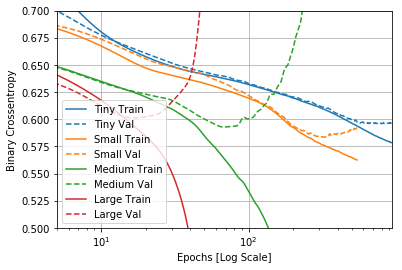

In [25]:
# Plot the training and validation losses
# The solid lines show the training loss, and the dashed lines show the validation loss
 
plotter.plot(size_histories)
a = plt.xscale('log')
plt.xlim([5, max(plt.xlim())])
plt.ylim([0.5, 0.7])
plt.xlabel("Epochs [Log Scale]")

In [30]:
# Strategies to prevent overfitting
# copy the training logs from the "Tiny" model above
shutil.rmtree(logdir/'regularizers/Tiny', ignore_errors=True)
shutil.copytree(logdir/'sizes/Tiny', logdir/'regularizers/Tiny')
regularizer_histories = {}
regularizer_histories['Tiny'] = size_histories['Tiny']

In [2]:
# Add weight regularization (L1 & L2)

l2_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001),
                 input_shape=(FEATURES,)),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(1)
])

regularizer_histories['l2'] = compile_and_fit(l2_model, "regularizers/l2")
 

NameError: name 'tf' is not defined

In [1]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7]) 

NameError: name 'plotter' is not defined

In [ ]:
result = l2_model(features)
regularization_loss=tf.add_n(l2_model.losses)

In [ ]:
# Add dropout

dropout_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(1)
])

regularizer_histories['dropout'] = compile_and_fit(dropout_model, "regularizers/dropout")

In [ ]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

In [ ]:
# Combined L2 + dropout

combined_model = tf.keras.Sequential([
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu', input_shape=(FEATURES,)),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(1)
])

regularizer_histories['combined'] = compile_and_fit(combined_model, "regularizers/combined")

In [ ]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

In [5]:
display.IFrame(
    src="https://tensorboard.dev/experiment/fGInKDo8TXes1z7HQku9mw/#scalars&_smoothingWeight=0.97",
    width = "100%",
    height="800px")


AttributeError: 'function' object has no attribute 'IFrame'